# Mask R-CNN Demo (Clothes Segmentation)

A quick intro to using the pre-trained model to detect and segment objects.

Run this Frist cell with pip install and then rerun this cell again with a comment in pip install

In [1]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)
#!pip install 'h5py==2.10.0' --force-reinstall

# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

TensorFlow 1.x selected.
1.15.2


In [2]:
#!pip install Cython
# !git clone https://github.com/cocodataset/cocoapi.git
# !pip install -U setuptools
# !pip install -U wheel
# !make install -C cocoapi/PythonAPI
!git clone https://github.com/pepper00023/fashion-test.git

fatal: destination path 'fashion-test' already exists and is not an empty directory.


In [3]:
import os
os.getcwd()
os.chdir('fashion-test')

In [4]:
!ls

assets	images_Instagram  MANIFEST.in  README.md	 samples    setup.py
images	LICENSE		  mrcnn        requirements.txt  setup.cfg


In [5]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
#sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
#import coco
from mrcnn import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_deepfashion2_0100.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "mask_rcnn/images")

Using TensorFlow backend.


## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the CocoConfig class in coco.py.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the CocoConfig class and override the attributes you need to change.

In [6]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    NAME ="test"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 13

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                26
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Create Model and Load Trained Weights

In [7]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our Dataset class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our Dataset class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the class_names property like this.

\# Load COCO dataset

dataset = coco.CocoDataset()

dataset.load_coco(COCO_DIR, "train")

dataset.prepare()

\# Print class names

print(dataset.class_names)

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [8]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['short_sleeved_shirt', 'long_sleeved_shirt', 'short_sleeved_outwear', 'long_sleeved_outwear', 'vest', 'sling', 
               'shorts', 'trousers', 'skirt', 'short_sleeved_dress', 'long_sleeved_dress',
               'vest_dress', 'sling_dress']

## Run Object Detection

In [9]:
!ls

assets	images_Instagram  MANIFEST.in  README.md	 samples    setup.py
images	LICENSE		  mrcnn        requirements.txt  setup.cfg


/content/fashion-test/images
Processing 1 images
image                    shape: (491, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 26)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32



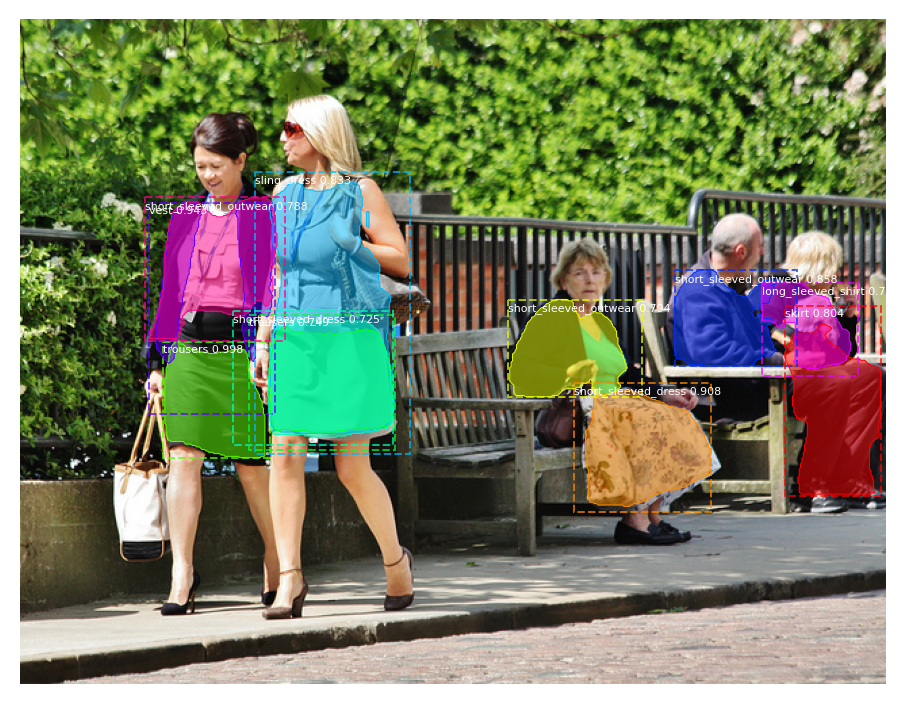

In [10]:
# Load a random image from the images folder
IMAGE_DIR = os.path.join(ROOT_DIR, "fashion-test/images")
print(IMAGE_DIR)
#file_names = next(os.walk(IMAGE_DIR))[2]
file_names = "9247489789_132c0d534a_z.jpg"
image = skimage.io.imread(os.path.join(IMAGE_DIR, file_names))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

In [11]:
!ls ..

fashion-test  mask_rcnn_deepfashion2_0100.h5  sample_data


In [12]:
!ls /content

fashion-test  mask_rcnn_deepfashion2_0100.h5  sample_data


In [13]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [14]:
!ls /content/gdrive/MyDrive/NewThesis_Poonyawat_Woottisart/Dataset_Filtered/

european-street-fashion-output	       ha-seg
eu-seg				       thai-street-fashion-output
harajuku-kawaii-street-fashion-output  th-seg


In [15]:
ROOT_DIR

'/content'

/content/gdrive/MyDrive/NewThesis_Poonyawat_Woottisart/Dataset/harajuku-kawaii-street-fashion
Processing 1 images
image                    shape: (1500, 1001, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 26)               min:    0.00000  max: 1500.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


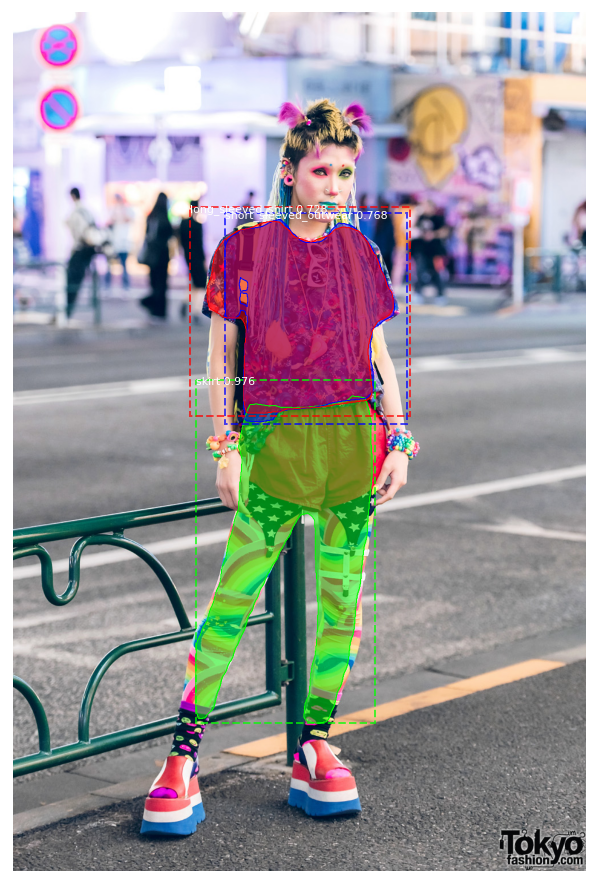

In [16]:
# Load a random image from the images folder
IMAGE_DIR = os.path.join(ROOT_DIR, "gdrive/MyDrive/NewThesis_Poonyawat_Woottisart/Dataset/harajuku-kawaii-street-fashion")
print(IMAGE_DIR)
#file_names = next(os.walk(IMAGE_DIR))[2]
file_names = "harajuku_4.jpg"
image = skimage.io.imread(os.path.join(IMAGE_DIR, file_names))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

/content/gdrive/MyDrive/NewThesis_Poonyawat_Woottisart/Dataset_Filtered/harajuku-kawaii-street-fashion-output
Processing 1 images
image                    shape: (1257, 450, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 26)               min:    0.00000  max: 1257.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


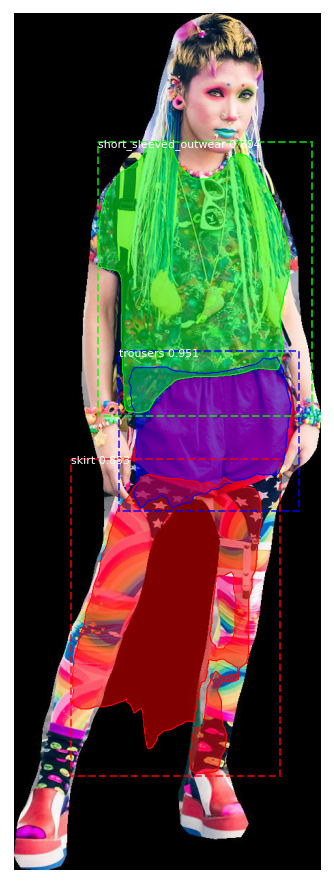

In [23]:
# Load a random image from the images folder
IMAGE_DIR = os.path.join(ROOT_DIR, "gdrive/MyDrive/NewThesis_Poonyawat_Woottisart/Dataset_Filtered/harajuku-kawaii-street-fashion-output")
print(IMAGE_DIR)
#file_names = next(os.walk(IMAGE_DIR))[2]
file_names = "test00003.jpg"
image = skimage.io.imread(os.path.join(IMAGE_DIR, file_names))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

In [ ]:
r['class_ids']

array([4], dtype=int32)

In [ ]:
class_names[:6] , class_names[6:9], class_names[9:]

(['short_sleeved_shirt',
  'long_sleeved_shirt',
  'short_sleeved_outwear',
  'long_sleeved_outwear',
  'vest',
  'sling'],
 ['shorts', 'trousers', 'skirt'],
 ['short_sleeved_dress', 'long_sleeved_dress', 'vest_dress', 'sling_dress'])

In [ ]:
Part = [[] for i in range(3)] # top-0, bottom-1, dress-2

for i in range(len(r['class_ids'])):
    if(r['class_ids'][i]<6):
        Part[0].append(i)
    elif(r['class_ids'][i]<9):
        Part[1].append(i)
    else:
        Part[2].append(i)

In [ ]:
Part[0]

[0]

In [ ]:
Part[1]

[]

In [ ]:
Part[2]

[]

In [ ]:
len(Part[1])

0

In [ ]:
write_path = os.path.join(ROOT_DIR, "gdrive/MyDrive/NewThesis_Poonyawat_Woottisart/Dataset_Filtered/eu-seg")

In [ ]:
size_h = len(r['masks'])
size_w = len(r['masks'][0])
for p in range(len(Part)):
    part_name = np.where(p==0, 'top', np.where(p==1, 'bottom', 'dress'))
    print('Part {}'.format(part_name))
    if(len(Part[p])!=0):
        write_loc = write_path+'/{}_00007.txt'.format(part_name)
        f = open(write_loc, 'w')
        for i in range(size_h):
            for j in range(size_w):
                temp = False
                for k in Part[p]:
                    temp = temp+r['masks'][i][j][k]
                if(temp):
                    print('i: {:04d}, j: {:04d}'.format(i, j))
                    f.writelines('{}, {}\n'.format(i,j))
        f.close()


Streaming output truncated to the last 5000 lines.
i: 0942, j: 0164
i: 0942, j: 0165
i: 0942, j: 0166
i: 0942, j: 0167
i: 0942, j: 0168
i: 0942, j: 0169
i: 0942, j: 0170
i: 0942, j: 0171
i: 0942, j: 0172
i: 0942, j: 0173
i: 0942, j: 0196
i: 0942, j: 0197
i: 0942, j: 0198
i: 0942, j: 0199
i: 0942, j: 0200
i: 0942, j: 0201
i: 0942, j: 0202
i: 0942, j: 0203
i: 0942, j: 0204
i: 0942, j: 0205
i: 0942, j: 0206
i: 0942, j: 0207
i: 0942, j: 0208
i: 0942, j: 0209
i: 0942, j: 0210
i: 0942, j: 0211
i: 0942, j: 0212
i: 0942, j: 0213
i: 0942, j: 0214
i: 0942, j: 0215
i: 0942, j: 0216
i: 0942, j: 0217
i: 0942, j: 0218
i: 0942, j: 0219
i: 0942, j: 0220
i: 0942, j: 0221
i: 0942, j: 0222
i: 0942, j: 0223
i: 0942, j: 0224
i: 0942, j: 0225
i: 0942, j: 0226
i: 0942, j: 0227
i: 0942, j: 0228
i: 0942, j: 0229
i: 0942, j: 0230
i: 0942, j: 0231
i: 0942, j: 0232
i: 0942, j: 0233
i: 0942, j: 0234
i: 0942, j: 0235
i: 0942, j: 0236
i: 0942, j: 0237
i: 0942, j: 0238
i: 0942, j: 0239
i: 0942, j: 0240
i: 0942, j: 02

In [ ]:
r

{'class_ids': array([4], dtype=int32), 'masks': array([[[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],
 
        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],
 
        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],
 
        ...,
 
        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],
 
        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],
 
        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]]]), 'rois': array([[ 159,   59, 1087,  365]], dtype=int32), 'scores': array([0.98878175], dtype=float32)}

In [ ]:
Part[0]

[0]

In [ ]:
write_path = os.path.join(ROOT_DIR, "gdrive/MyDrive/NewThesis_Poonyawat_Woottisart/Dataset_Filtered/th-seg")

In [ ]:
# Load a random image from the images folder
IMAGE_DIR = os.path.join(ROOT_DIR, "gdrive/MyDrive/NewThesis_Poonyawat_Woottisart/Dataset_Filtered/thai-street-fashion-output")
print(IMAGE_DIR)
#file_names = next(os.walk(IMAGE_DIR))[2]
for file_names in os.listdir(IMAGE_DIR):
    image = skimage.io.imread(os.path.join(IMAGE_DIR, file_names))

    # Run detection
    results = model.detect([image], verbose=0)

    # Visualize results
    r = results[0]

    name = file_names.replace('test' ,'').replace('.jpg', '')
    name = int(name)

    Part = [[] for i in range(3)] # top-0, bottom-1, dress-2

    for i in range(len(r['class_ids'])):
        if(r['class_ids'][i]<6):
            Part[0].append(i)
        elif(r['class_ids'][i]<9):
            Part[1].append(i)
        else:
            Part[2].append(i)

    size_h = len(r['masks'])
    size_w = len(r['masks'][0])
    for p in range(len(Part)):
        part_name = np.where(p==0, 'top', np.where(p==1, 'bottom', 'dress'))
        print('Part {}'.format(part_name))
        if(len(Part[p])!=0):
            write_loc = write_path+'/{}_{:05d}.txt'.format(part_name, name)
            f = open(write_loc, 'w')
            for i in range(size_h):
                for j in range(size_w):
                    temp = False
                    for k in Part[p]:
                        temp = temp+r['masks'][i][j][k]
                    if(temp):
                        # print('i: {:04d}, j: {:04d}'.format(i, j))
                        f.writelines('{}, {}\n'.format(i,j))
            f.close()
    # try:
    #     image = skimage.io.imread(os.path.join(IMAGE_DIR, file_names))

    #     # Run detection
    #     results = model.detect([image], verbose=0)

    #     # Visualize results
    #     r = results[0]

    #     name = file_names.replace('test' ,'').replace('.jpg', '')
    #     name = int(name)

    #     size_h = len(r['masks'])
    #     size_w = len(r['masks'][0])
    #     for p in range(len(Part)):
    #         part_name = np.where(p==0, 'top', np.where(p==1, 'bottom', 'dress'))
    #         print('Part {}'.format(part_name))
    #         if(len(Part[p])!=0):
    #             write_loc = write_path+'/{}_{:05d}.txt'.format(part_name, name)
    #             f = open(write_loc, 'w')
    #             for i in range(size_h):
    #                 for j in range(size_w):
    #                     temp = False
    #                     for k in Part[p]:
    #                         temp = temp+r['masks'][i][j][k]
    #                     if(temp):
    #                         # print('i: {:04d}, j: {:04d}'.format(i, j))
    #                         f.writelines('{}, {}\n'.format(i,j))
    #             f.close()






    # except:
    #     print('Unable to detect {}'.format(file_names))


/content/gdrive/MyDrive/NewThesis_Poonyawat_Woottisart/Dataset_Filtered/thai-street-fashion-output
Part top
Part bottom
Part dress
Part top
Part bottom
Part dress
Part top
Part bottom
Part dress
Part top
Part bottom
Part dress
Part top
Part bottom
Part dress
Part top
Part bottom
Part dress
Part top
Part bottom
Part dress
Part top
Part bottom
Part dress
Part top
Part bottom
Part dress
Part top
Part bottom
Part dress
Part top
Part bottom
Part dress
Part top
Part bottom
Part dress
Part top
Part bottom
Part dress
Part top
Part bottom
Part dress
Part top
Part bottom
Part dress
Part top
Part bottom
Part dress
Part top
Part bottom
Part dress
Part top
Part bottom
Part dress
Part top
Part bottom
Part dress
Part top
Part bottom
Part dress
Part top
Part bottom
Part dress
Part top
Part bottom
Part dress
Part top
Part bottom
Part dress
Part top
Part bottom
Part dress
Part top
Part bottom
Part dress
Part top
Part bottom
Part dress
Part top
Part bottom
Part dress
Part top
Part bottom
Part dress
Part 

In [ ]:
IMAGE_DIR = os.path.join(ROOT_DIR, "gdrive/MyDrive/NewThesis_Poonyawat_Woottisart/Dataset_Filtered/european-street-fashion-output")
print(IMAGE_DIR)

/content/gdrive/MyDrive/NewThesis_Poonyawat_Woottisart/Dataset_Filtered/european-street-fashion-output


In [ ]:
len(r['masks']), len(r['masks'][0]), len(r['masks'][0][0])

(457, 328, 1)